# Cuantificación Vectorial para Compresión de Imágenes en Escala de Grises

## Itzanami Berlanga Contreras | 06 de junio del 2024



En esta proyecto el propósito es integrar los conocimientos recabados a lo largo de la UDA. 

Así, integraremos conceptos de aprendizaje máquina y optimización inteligente, para hacer en este caso un ejercicio de compresión de imágenes en escalas de grises. Para esto, nos es muy útil entender algunos conceptos, que intentaré definir para poner en contexto el resto del código.
- Encoder: Este tiene la función de tomar en este caso una matriz, que representa una imagen, y cambiar su representación por otra mediante algún procesamiento, ejemplos de esto han sido los filtros convolucionales revisados durante la práctica pasada, y en esta práctica el procedimiento se realizará a través de un codebook. En general al aplicar estas funciones la dimensión de la matriz disminuye.
- Decoder: Tiene la función de tomar la matriz encodeada y regresarla a su dimensión original, en este caso se hará el proceso de tomar los codewords del codebook para realizar una reconstrucción en escala de grises.
- Codebook y codeword: En este caso, entenderemos por codebook al conjunto de codewords que harán la compresión de la imagen, cada codeword representa un bloque de la imagen, y se intentará encontrar el mejor grupo de estos bloques para representar la imagen ya existente.

Para esto seguimos los siguientes pasos:

## Cargar las librerías e imágenes

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import random 
import math
import cv2

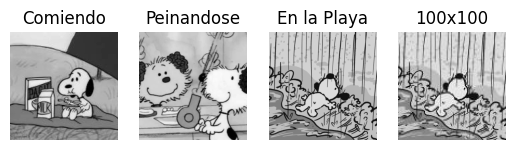

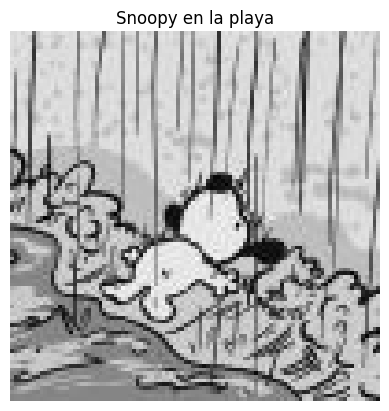

In [32]:
file = ["Snoopy Comiendo.jpg", "Snoopy bano.jpg", 
        "Snoopy Playa.jpg", "Snoopy Playa100.jpg"]
imgs = []
sizes = []

titles = ["Comiendo", "Peinandose", "En la Playa", "100x100"]

fig, axs = plt.subplots(nrows=1, ncols=4)

for i in range(len(file)):
    imgs.append(cv2.imread(file[i], cv2.IMREAD_GRAYSCALE))#/255.0
    sizes.append(imgs[i].shape[0])
    axs[i].axis('off')
    axs[i].imshow(imgs[i], cmap='gray')
    axs[i].set_title(titles[i])
    
#plt.suptitle("Snoopy")
plt.show()
plt.imshow(imgs[3], cmap='gray')
plt.title("Snoopy en la playa")
plt.axis('off')
plt.show()

## Función Split, Encode y Decode

Para poder realizar el proceso del encoder, dada la naturaleza del codebook donde cada codeword representará un bloque de la imagen, es necesario que nuestra imagen original sea dividida en bloques del mismo tamaño, a modo que podamos hacer el reemplazo durante el proceso de encodear y decodear nuestra imagen.

El proceso de encode aplica en la elección del codeword un 1-NN, para escoger al bloque que más se le asemeje.

In [40]:
# División de imagen en bloques
def split(img, block_size):
    h, w = img.shape
    bloques = [img[i:i+block_size, j:j+block_size]
               for i in range(0, h, block_size)
               for j in range(0, w, block_size)]
    return np.array(bloques)

# Encodeo de bloques usando KNN
def encode(imagen_partida, codebook, lado):
    codebook_keys = np.arange(len(codebook))
    knn = KNN_1()
    knn.train(codebook, codebook_keys)
    imagen_encode = np.array([knn.predict(bloque.reshape(1, -1)) for bloque in imagen_partida])
    return imagen_encode.flatten()

# Decodeo de imagen usando codebook
def decode(imagen_partida, codebook, lado):
    bloques_decodeados = [codebook[int(idx)].reshape(lado, lado) for idx in imagen_partida]
    bloques_decodeados = np.array(bloques_decodeados)
    h = int(np.sqrt(len(bloques_decodeados))) * lado
    w = h
    img_reconstruida = np.zeros((h, w))
    indice = 0
    for i in range(0, h, lado):
        for j in range(0, w, lado):
            img_reconstruida[i:i+lado, j:j+lado] = bloques_decodeados[indice]
            indice += 1
    return img_reconstruida

## Función de Aptitud

Para realizar un proceso de optimización es necesario tener una función sobre la cuál optimizar, en este caso, la pérdida tal como fue definida en los requisitos de este proyecto está dada por la distorsión de la imagen, que es la suma de las diferencias al cuadrado entre la imagen decodeada con la original, sobre la cantidad de codewords que se tiene.  

In [34]:
# Función de aptitud
def aptitud(imagen, particula, cant_codewords, size_codewords):
    lado = int(math.sqrt(size_codewords))
    codebook = np.reshape(particula, (cant_codewords, lado * lado))
    imagen_partida = split(imagen, lado)
    imagen_partida_encode = encode(imagen_partida, codebook, lado)
    imagen_partida_decode = decode(imagen_partida_encode, codebook, lado)
    distorsion = np.sum((imagen_partida.reshape(-1, lado * lado) - imagen_partida_decode.reshape(-1, lado * lado))**2)
    return distorsion / cant_codewords

## KNN

En este caso se trata de un 1-NN, por lo que no recibe parámetro K.

In [35]:
class KNN_1:

    def __init__(self):
        self.X_tr = None
        self.Y_tr = None

    def train(self, X, y):
        self.X_tr = X
        self.Y_tr = y
            
    def predict(self, X):        
        Y_tags = np.zeros(len(X))
        for i in range(len(X)):
            distancias = np.linalg.norm(self.X_tr - X[i], axis=1)
            Y_tags[i] = self.Y_tr[np.argmin(distancias)]
        return Y_tags

## PCO: Particle Swarm Optimization

Este algoritmo fue el utilizado para realizar la optimización, tiene diversos parámetros entre los que se pueden ajustar la cantidad de partículas que se manejan, las épocas de entrenamiento, así como el tamaño y cantidad de codewords que correspondan al problema en cuestión.

Es importante resaltar en el procedimiento el ajuste de las partículas para que estas se mantuvieran en el rango adecuado para representar un bloque de color.

In [53]:
class PCO:
    def __init__(self, size_codewords = 2, cant_codewords = 10, cant_particulas = 30, epocas = 1000):
        self.cant_codewords = cant_codewords
        self.size_codewords = size_codewords
        self.dimension = size_codewords*cant_codewords
        self.cant_particles = cant_particulas
        self.particles = None
        self.velocidad = None
        self.aptitud = None
        self.p_best = None
        self.p_best_aptitud = None
        self.g = None
        self.epocas = epocas
        self.phi = [2.05, 2.05]
        self.phi_sum = sum(self.phi)
        self.chi = 2/(self.phi_sum-2+(self.phi_sum**2 - 4 *self.phi_sum)**0.5)      
        
    def train(self, imagen):
        self.imagen = imagen
        self.particles = [random.randint(0, 256) for _ in range(self.cant_particles*self.dimension)]
        self.particles = np.reshape(self.particles, (self.cant_particles, self.dimension))
        self.velocidad = [random.randint(0, 256) for _ in range(self.dimension*self.cant_particles)]
        self.velocidad = np.reshape(self.velocidad, (self.cant_particles, self.dimension))
        self.aptitud = np.zeros(self.cant_particles)
        self.apt_training = []
        # Calcula la aptitud
        for i in range(self.cant_particles):
            self.aptitud[i] = self.calc_aptitud(self.particles[i])
        self.p_best = self.particles.copy()
        self.p_best_aptitud = self.aptitud.copy()
        
        for epoch in range(self.epocas):
            # Calcula aptitud
            for j in range(self.cant_particles):
                self.aptitud[j] = self.calc_aptitud(self.particles[j])
                # Comparar con el mejor estado de dicha particula y reemplazar de ser necesario
                if self.aptitud[j] < self.p_best_aptitud[j]:
                    self.p_best_aptitud[j] = self.aptitud[j]
                    self.p_best[j] = self.particles[j].copy()
            # Encontrar mejor partícula de la población
            self.g = np.argmin(self.aptitud)
            self.apt_training.append((epoch, self.g))
            # Actualizar velocidad y posición de cada partícula
            for j in range(self.cant_particles):
                u1 = [random.uniform(0, self.phi[0]) for _ in range(self.dimension)]
                u2 = [random.uniform(0, self.phi[1]) for _ in range(self.dimension)]
                self.velocidad[j] = self.chi*(u1*(self.p_best[j] - self.particles[j]) + u2*(self.p_best[self.g] - self.particles[j]))
                self.particles[j] = np.clip(self.particles[j] + self.velocidad[j], 0, 255)
                
    def mejor_particula(self):
        return self.p_best[np.argmin(self.p_best_aptitud)]
    
    # Ayuda a visualizar la aptitud de la mejor partícula por época a lo largo del entrenamiento.
    def graph_train(self, title = ""):
        x_axis = np.zeros(len(self.apt_training))
        y_axis = np.zeros(len(self.apt_training))
        
        for i in range(len(self.apt_training)):
            x_axis[i] = self.apt_training[i][0]
            y_axis[i] = self.apt_training[i][1]
        
        plt.title("Aptitus más baja de cada población" + title)
        plt.xlabel("Época")
        plt.ylabel("Aptitud")
        plt.plot(x_axis, y_axis)
    
    def calc_aptitud(self, particula):
        apt = aptitud(self.imagen, particula, self.cant_codewords, self.size_codewords)
        return apt

## Visualización de la imagen comprimida

In [73]:
def print_result(resultado, imagen, lado, cant_codewords, title = ""):
    codebook = np.reshape(resultado, (cant_codewords, lado*lado))
    imagen_partida = split(imagen, lado)
    imagen_partida_encode = encode(imagen_partida, codebook, lado)
    imagen_partida_decode = decode(imagen_partida_encode, codebook, lado)
    plt.imshow(imagen_partida_decode, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Resultados

A continuación se presentan diversas instancias del uso de este algoritmo, incluyendo el desarrollo de la aptitud de las partículas a lo largo del entrenamiento y el resultado de la compresión, donde podemos analizar mejor que función tiene la cantidad de codewords y tamaño de bloque escogido.

In [82]:
Snoopy_Comiendo_PCO = PCO(size_codewords = 4, cant_codewords = 10, epocas=100)
Snoopy_Comiendo_PCO.train(imgs[0])
resultado = Snoopy_Comiendo_PCO.mejor_particula()
print(resultado)

[116 181 118  47 173  15  56 179 142 179   1 171 141 157  63  78 141 134
  59 128 187  52  42 224  58 112 198  86  10 124  22 231 123 233  73  87
 139 135 105 108]


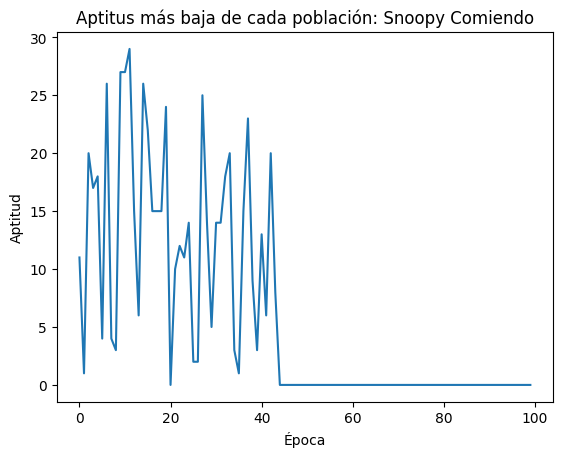

In [83]:
Snoopy_Comiendo_PCO.graph_train(": Snoopy Comiendo")

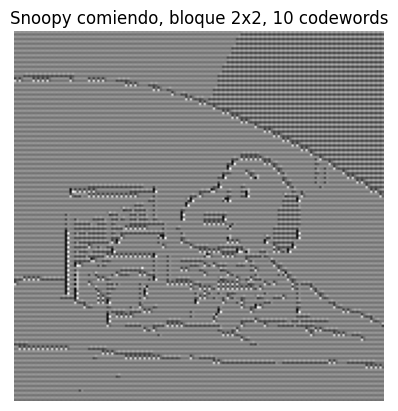

In [84]:
print_result(resultado, imgs[0], 2, 10, "Snoopy comiendo, bloque 2x2, 10 codewords")

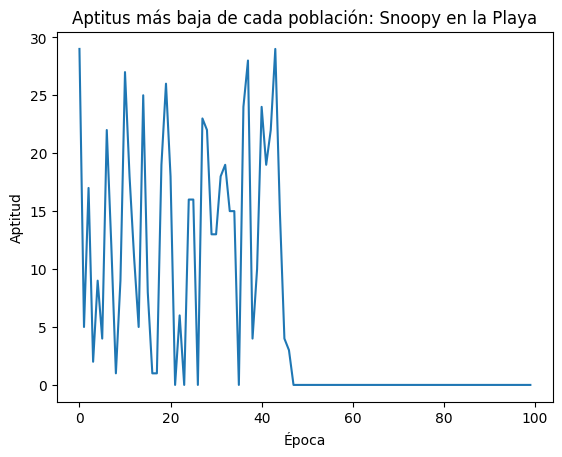

In [77]:
Snoopy_Playa100_PCO = PCO(size_codewords = 16, cant_codewords = 15, epocas=100)
Snoopy_Playa100_PCO.train(imgs[3])
resultado = Snoopy_Playa100_PCO.mejor_particula()
Snoopy_Playa100_PCO.graph_train(": Snoopy en la Playa")

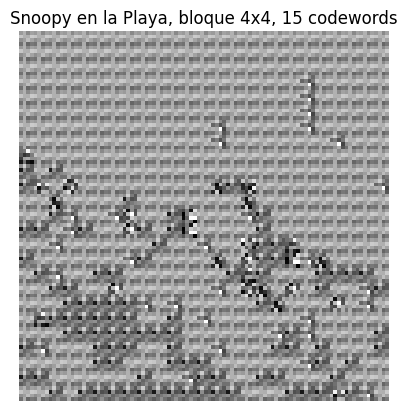

In [79]:
print_result(resultado, imgs[3], 4, 15, "Snoopy en la Playa, bloque 4x4, 15 codewords")

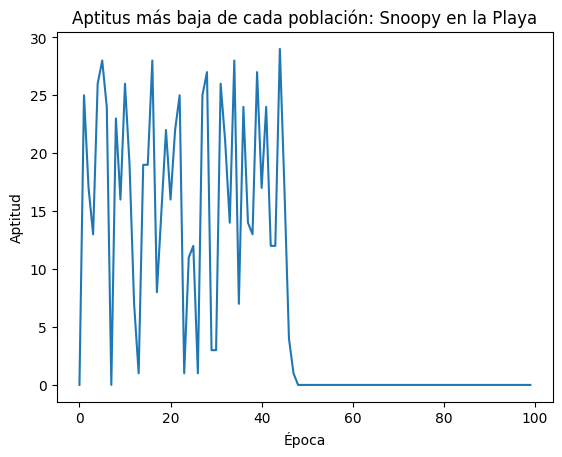

In [87]:
Snoopy_Playa_PCO = PCO(size_codewords = 16, cant_codewords = 15, epocas=100)
Snoopy_Playa_PCO.train(imgs[2])
resultado_Playa = Snoopy_Playa_PCO.mejor_particula()
Snoopy_Playa_PCO.graph_train(": Snoopy en la Playa")

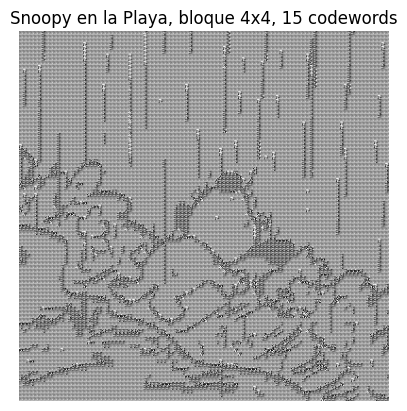

In [88]:
print_result(resultado_Playa, imgs[2], 4, 15, "Snoopy en la Playa, bloque 4x4, 15 codewords")

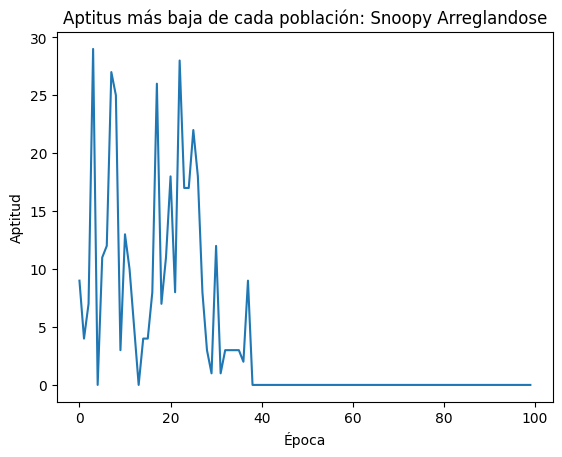

In [97]:
Snoopy_Banio_PCO = PCO(size_codewords = 16, cant_codewords = 20, epocas=100)
Snoopy_Banio_PCO.train(imgs[1])
resultado = Snoopy_Banio_PCO.mejor_particula()
Snoopy_Banio_PCO.graph_train(": Snoopy Arreglandose")

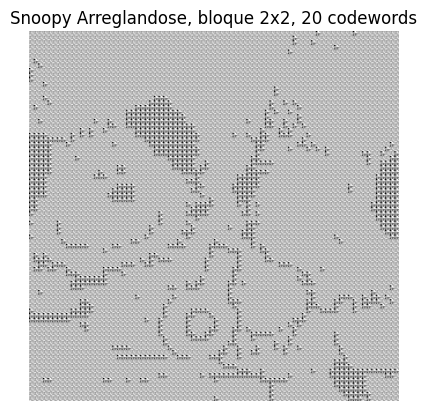

In [99]:
print_result(resultado, imgs[1], 4, 20, "Snoopy Arreglandose, bloque 2x2, 20 codewords")

# Conclusiones

Este ejercicio demostró con éxito la implementación de técnicas de procesamiento de imágenes mediante la división en bloques, la codificación utilizando un codebook con KNN, y la optimización del codebook mediante Particle Swarm Optimization (PCO). Pudimos analizar mejor el papel que tienen la elección del tamaño del bloque así como la cantidad de codewords utilizadas, donde podemos encontrar una mayor o menor fidelidad con la imagen original al trabajar con bloques más pequeños o en su caso con más codewords, también es importante encontrar el balance entre ambos para que el proceso de compresión no se haga en vano, dado que aumentar la fidelidad aumenta la complejidad y tiempo de procesamiento. 